In [27]:
pip install opacus

Training baseline model...
Training DP model...
[DP] Training with σ=0.5, C=1.0, lr=0.01


/usr/local/lib/python3.12/dist-packages/opacus/privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
sys:1: UserWarning: Full backward hook is firing when gradients are computed with respect to module outputs since no inputs require gradients. See https://docs.pytorch.org/docs/main/generated/torch.nn.Module.html#torch.nn.Module.register_full_backward_hook for more details.


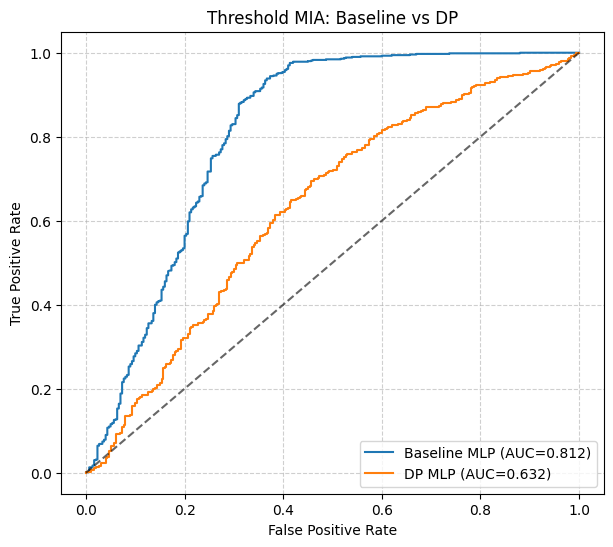

Baseline MLP TPR@FPR<=0.100: 0.2843
DP MLP       TPR@FPR<=0.100: 0.1671
Baseline MLP TPR@FPR<=0.010: 0.0129
DP MLP       TPR@FPR<=0.010: 0.0057
Baseline MLP TPR@FPR<=0.001: 0.0014
DP MLP       TPR@FPR<=0.001: 0.0029


In [ ]:
# --- Threshold MIA: Baseline vs DP on dataset.csv ---
# Goal: Compare membership inference risk between a normal model and a DP-protected model
#       by training both and plotting ROC curves from per-example losses.

import pandas as pd, numpy as np, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import roc_curve, auc
import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# Try to import Opacus (DP training). Skip if unavailable.
try:
    from opacus import PrivacyEngine
    OPACUS_AVAILABLE = True
except:
    OPACUS_AVAILABLE = False


# ---  1. Load dataset ---
df = pd.read_csv("dataset.csv")
assert {"job_description", "job_role"} <= set(df.columns), "Dataset missing required columns."

# Remove label words (like 'data scientist') from job descriptions — avoids leakage.
label_words = df["job_role"].unique()
def clean_text(txt):
    s = str(txt)
    for w in label_words:
        s = s.replace(w, "")
    return s
df["text_safe"] = df["job_description"].apply(clean_text)


# ---  2. Encode labels & TF-IDF ---
# Encode job_role labels numerically and convert cleaned text into TF-IDF features
le = LabelEncoder()
y_all = le.fit_transform(df["job_role"])
tfidf = TfidfVectorizer(ngram_range=(1,3), max_features=40_000)
X_all = tfidf.fit_transform(df["text_safe"])


# ---  3. Train-test split ---
# 70% train, 30% test (stratified to keep class balance)
train_idx, test_idx = train_test_split(
    np.arange(len(y_all)), test_size=0.30, stratify=y_all, random_state=6905
)
Xtr, ytr = X_all[train_idx], y_all[train_idx]
Xte, yte = X_all[test_idx], y_all[test_idx]


# --- Torch dataset/model helpers ---
device = "cuda" if torch.cuda.is_available() else "cpu"

# Converts TF-IDF sparse matrix into a Torch dataset for batching
class CSRDataset(Dataset):
    def __init__(self, X, y): self.X, self.y = X, y
    def __len__(self): return self.X.shape[0]
    def __getitem__(self, idx):
        return torch.tensor(self.X[idx].toarray()[0], dtype=torch.float32), \
               torch.tensor(int(self.y[idx]), dtype=torch.long)

# Simple 2-layer MLP for text classification
def make_model(input_dim, num_classes, device, hidden_units=512):
    return nn.Sequential(
        nn.Linear(input_dim, hidden_units),
        nn.ReLU(),
        nn.Linear(hidden_units, num_classes)
    ).to(device)

# Compute per-example cross-entropy losses (used to infer membership later)
@torch.no_grad()
def per_example_losses(model, X, y):
    loader = DataLoader(CSRDataset(X, y), batch_size=128, shuffle=False)
    crit = nn.CrossEntropyLoss(reduction="none")
    model.eval()
    losses = []
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        losses.extend(crit(model(xb), yb).cpu().numpy())
    return np.array(losses)


# --- Training function for both Baseline and DP models ---
def train_mlp(Xtr, ytr, Xva, yva,
              epochs=20,
              lr=5e-4,
              use_dp=False,
              dp_noise=0.5,
              dp_clip=1.0,
              hidden_units=512):
    """
    Trains a standard or DP MLP depending on use_dp flag.
    DP version uses Opacus to add noise to gradients and clip sensitivity.
    """
    model = make_model(Xtr.shape[1], len(np.unique(ytr)), device, hidden_units)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    crit = nn.CrossEntropyLoss()
    tr_loader = DataLoader(CSRDataset(Xtr, ytr), batch_size=64, shuffle=True)

    if use_dp:
        # Wrap model and optimizer with Opacus PrivacyEngine
        privacy_engine = PrivacyEngine()
        model, opt, tr_loader = privacy_engine.make_private(
            module=model,
            optimizer=opt,
            data_loader=tr_loader,
            noise_multiplier=dp_noise,
            max_grad_norm=dp_clip,
        )
        print(f"[DP] Training with σ={dp_noise}, C={dp_clip}, lr={lr}")

    # --- Main training loop ---
    for _ in range(epochs):
        model.train()
        for xb, yb in tr_loader:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad()
            loss = crit(model(xb), yb)
            loss.backward()
            opt.()

    return model


# ---  4. Train baseline & DP models ---
print("Training baseline model...")
baseline = train_mlp(Xtr, ytr, Xte, yte, lr=5e-4, use_dp=False)

print("Training DP model...")
if OPACUS_AVAILABLE:
    dp_model = train_mlp(Xtr, ytr, Xte, yte,
                         lr=0.01,
                         use_dp=True,
                         dp_noise=1.5,
                         dp_clip=0.17)
else:
    dp_model = None
    print("Opacus not installed, skipping DP model.")


# ---  5. Compute per-example losses for both models ---
# Lower loss = model thinks the example was "familiar" → likely part of training set.
loss_train_base = per_example_losses(baseline, Xtr, ytr)
loss_test_base  = per_example_losses(baseline, Xte, yte)

if dp_model:
    loss_train_dp = per_example_losses(dp_model, Xtr, ytr)
    loss_test_dp  = per_example_losses(dp_model, Xte, yte)


# ---  6. Threshold MIA: compute ROC and AUC ---
# Membership label: 1=train, 0=test
labels = np.concatenate([np.ones_like(loss_train_base), np.zeros_like(loss_test_base)])

# Baseline MLP attack scores (negative loss → higher means "more confident member")
scores_base = np.concatenate([-loss_train_base, -loss_test_base])
fpr_b, tpr_b, _ = roc_curve(labels, scores_base)
auc_b = auc(fpr_b, tpr_b)

# DP MLP attack scores (if DP model exists)
plt.figure(figsize=(7,6))
plt.plot(fpr_b, tpr_b, label=f"Baseline MLP (AUC={auc_b:.3f})")

if dp_model:
    scores_dp = np.concatenate([-loss_train_dp, -loss_test_dp])
    fpr_dp, tpr_dp, _ = roc_curve(labels, scores_dp)
    auc_dp = auc(fpr_dp, tpr_dp)
    plt.plot(fpr_dp, tpr_dp, label=f"DP MLP (AUC={auc_dp:.3f})")

# Random baseline reference
plt.plot([0,1],[0,1],'k--',alpha=0.6)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Threshold MIA: Baseline vs DP")
plt.grid(True, which="both", ls="--", alpha=0.6)
plt.legend()
plt.show()


# ---  7. Print TPR at fixed low FPR thresholds ---
# Helps compare how easily an attacker can identify members at tight privacy budgets.
def tpr_at_fpr(fpr, tpr, thr):
    idx = np.where(fpr <= thr)[0]
    return float(tpr[idx].max()) if idx.size > 0 else 0.0

for thr in [0.1, 0.01, 0.001]:
    print(f"Baseline MLP TPR@FPR<={thr:.3f}: {tpr_at_fpr(fpr_b, tpr_b, thr):.4f}")
    if dp_model:
        print(f"DP MLP       TPR@FPR<={thr:.3f}: {tpr_at_fpr(fpr_dp, tpr_dp, thr):.4f}")
